In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import pystan
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing and Visualization

In [2]:
data = pd.read_csv("weekly_in_situ_co2_mlo.csv",
                   names=["Date", "CO2 levels (ppm)"])

# convert the date from string to a datetime object
data["Date"] = pd.to_datetime(data["Date"])

# For modeling purposes we represent the column 'Days'
# using the number of days since measurements started in 1958.
# We assume the date of the first measurement (March 29, 1958) 
# as starting point, not January 1, 1958!
data["Days since 1958"] = (data.iloc[:, 0] - data.iloc[0, 0]).dt.days


print(f"Dataset size: {data.shape[0]} rows, {data.shape[1]} columns")
print(f"There are {sum(data.isnull().sum())} null values across the entire dataset")
data.head()

Dataset size: 3242 rows, 3 columns
There are 0 null values across the entire dataset


,Date,CO2 levels (ppm),Days since 1958
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


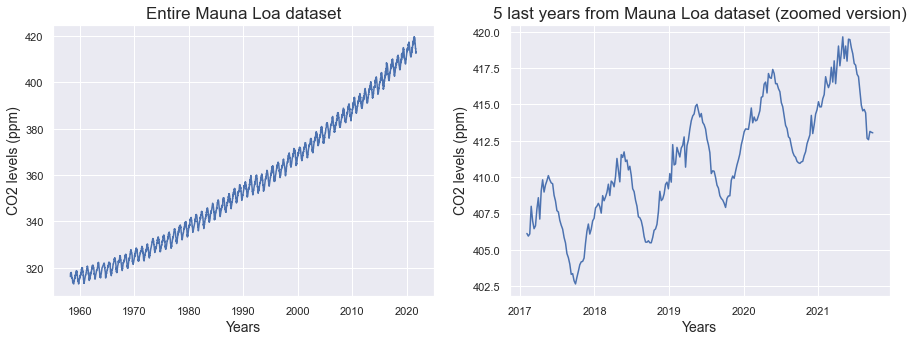

In [3]:
# entire dataset
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(data["Date"], data["CO2 levels (ppm)"])
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("Entire Mauna Loa dataset", size=17)

# 5 last years to make the  make the trend, seasonal variation, 
# and noise clearer
plt.subplot(1, 2, 2)
plt.plot(data["Date"][3000:], data["CO2 levels (ppm)"][3000:])
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("5 last years from Mauna Loa dataset (zoomed version)", size=17)
plt.show()

# Default model

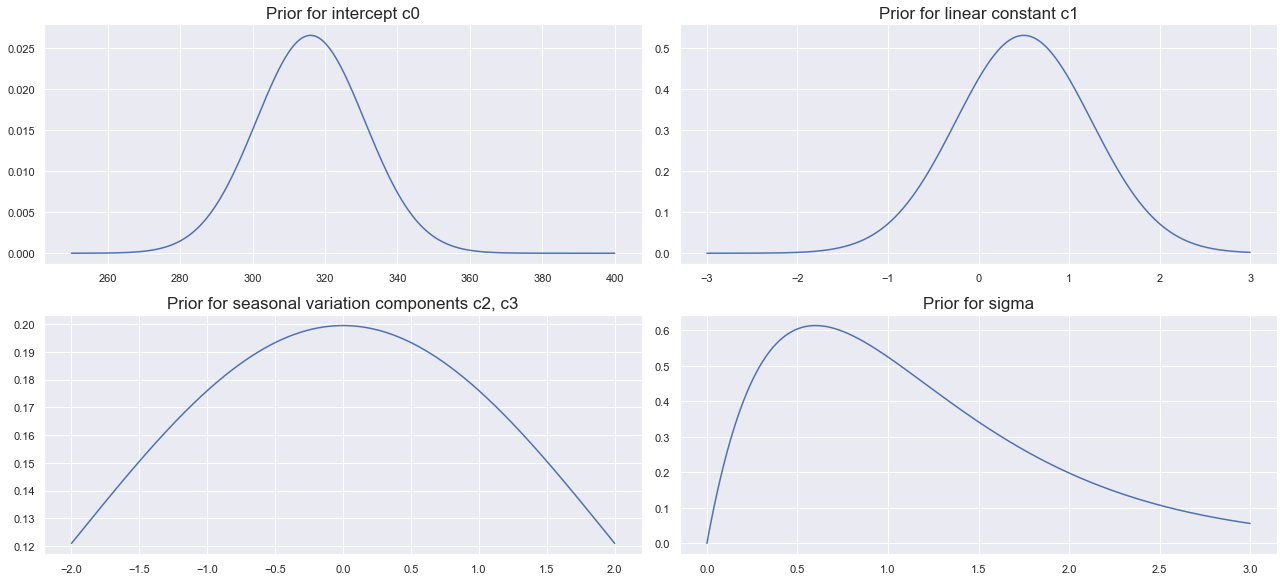

In [4]:
figure = plt.figure(figsize=(18,12))

# Prior for intercept
plt.subplot(321)
x = np.linspace(250,400,1000)
plt.plot(x, sts.norm.pdf(x,316, 15))
plt.title("Prior for intercept c0", size=17)

# Prior for linear constant c1
plt.subplot(322)
x = np.linspace(-3,3,1000)
plt.plot(x, sts.norm.pdf(x,0.5, 0.75))
plt.title("Prior for linear constant c1", size=17)

# Prior for seasonal variation components c2, c3
plt.subplot(323)
x = np.linspace(-2,2,1000)
plt.plot(x, sts.norm.pdf(x,0, 2))
plt.title("Prior for seasonal variation components c2, c3", size=17)

# Prior for sigma
plt.subplot(324)
x = np.linspace(0,3,1000)
plt.plot(x, sts.gamma.pdf(x,a=2, scale=0.6))
plt.title("Prior for sigma", size=17)

figure.tight_layout()

plt.show()

In [5]:
default = """
data {
    int<lower=0> N; // number of entries
    int<lower=0> N_future; // number of entries after the most recent one
    real<lower=0> days[N]; // array for date
    real<lower=0> co2_lvl[N]; // array for C02 levels
    real<lower=0> period; // 2*pi
}

parameters {
    real<lower=0> c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> sigma;
}

model {
    // prior
    c0 ~ normal(316, 15); // intercept
    c1 ~ normal(0.5, 0.75); // slope
    c2 ~ normal(0, 2); // seasonal variation component
    c3 ~ normal(0, 2); // seasonal variation component
    
    sigma ~ gamma(2, 0.6);
    
    // likelihood
    for (i in 1:N) {
        co2_lvl[i] ~ normal(c0 + c1*days[i] + c2*cos(period*days[i]/ 365.25 + c3), sigma);
    }

}


// Generate a normal variate with location mu and scale sigma
generated quantities {
    
    real co2_future[N_future];
    
    for(t in 1:N_future) {
        co2_future[t] = normal_rng(
            c0 + c1*(7*t + days[N]) + c2*cos(period*(7*t + 
            days[N])/ 365.25 + c3), sigma);
    }
}


"""
default_model = pystan.StanModel(model_code=default)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_158ba79c37dc432cd19f11873a76f850 NOW.


In [6]:
# make sure the first measurement of 2060 is included
future_present_day_diff = datetime.strptime('Jan 15 2060', '%b %d %Y')-max(data["Date"])
# since the measurements are weekly, divide by 7
future_n = int(future_present_day_diff.days/7)

# specify data for Stan
stan_default = {
    "N": data.shape[0],
    "N_future": future_n,
    "days": data["Days since 1958"],
    "co2_lvl": data["CO2 levels (ppm)"],
    "period": 2*np.pi
    } 

# default results summary from model
default_res = default_model.sampling(data=stan_default, control = {"max_treedepth": 15})
default_samples = default_res.extract()
default_params = ["c0", "c1", "c2", "c3", "sigma"]
print(default_res.stansummary(pars=default_params))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_158ba79c37dc432cd19f11873a76f850.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    305.45  2.4e-3   0.15 305.16 305.35 305.45 305.55 305.74   3959    1.0
c1    4.4e-3  1.8e-7 1.1e-5 4.4e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   3773    1.0
c2      2.62  2.4e-3    0.1   2.42   2.55   2.63    2.7   2.82   1900    1.0
c3    3.3e-3  6.0e-5 3.2e-3 7.6e-5 9.5e-4 2.3e-3 4.5e-3   0.01   2843    1.0
sigma   4.17  1.1e-3   0.05   4.07   4.14   4.17   4.21   4.28   2234    1.0

Samples were drawn using NUTS at Tue Dec 14 01:10:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


**WARNING:** The cell above might not always show convergence. A possible solution is to re-run 2 cells above. I do not think this is the best solution. However, after trying multiple constraints, priors and restructuring the model, I am not entirely sure how to guarantee 100% convergence. This might have something to do with randomness Stan provides in the modeling process. No matter which model we have previously run in class, the values were not completely same.

In [16]:
pystan.check_hmc_diagnostics(default_res)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [17]:
# extract the mean model estimates 
c0_default = default_res.extract()["c0"].mean()
c1_default = default_res.extract()["c1"].mean()
c2_default = default_res.extract()["c2"].mean()
c3_default = default_res.extract()["c3"].mean()
sigma_default = default_res.extract()["sigma"].mean()

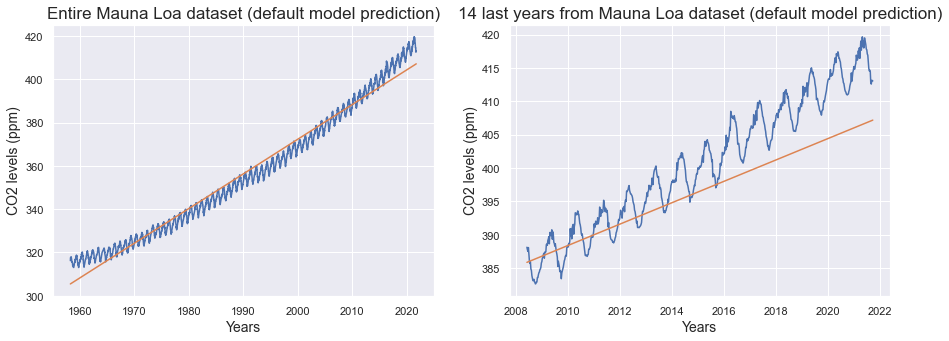

In [18]:
# CO2 values from the linear model
default_vals = c0_default + c1_default * data["Days since 1958"].values

# entire dataset
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(data["Date"], data["CO2 levels (ppm)"])
plt.plot(data["Date"], default_vals)
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("Entire Mauna Loa dataset (default model prediction)", size=17)

# 5 last years to make the  make the trend, seasonal variation, 
# and noise clearer
plt.subplot(1, 2, 2)
plt.plot(data["Date"][2550:], data["CO2 levels (ppm)"][2550:])
plt.plot(data["Date"][2550:], default_vals[2550:])
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("14 last years from Mauna Loa dataset (default model prediction)", size=17)
plt.show()

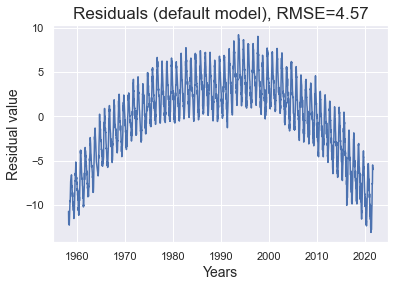

In [19]:
# find the residuals
default_residuals = default_vals-data["CO2 levels (ppm)"]

# calculate RMSE
default_rmse = np.round(np.mean((default_residuals)**2)**0.5, 2)

# plot the results
plt.plot(data["Date"], default_residuals)
plt.title(f"Residuals (default model), RMSE={default_rmse}", size=17)
plt.xlabel("Years", size=14)
plt.ylabel("Residual value", size=14)
plt.show()

In [20]:
# predictions for 2021-2060
preds_dates = pd.date_range(data["Date"].iloc[-1], "2060-01-15", freq='W-Fri')

preds_co2_default = default_res.extract()["co2_future"]
print(preds_co2_default.shape)
preds_co2_default = preds_co2_default.mean(axis=0)
#print(preds_co2_default)

(4000, 1998)


In [21]:
# This cell was used to redo the "generated quantities" part
# of the Stan model using sts.norm.rvs()
vals = []
for i in range(future_n):
    res = sts.norm(c0_default + c1_default*(data["Days since 1958"].iloc[-1]+7*i) + c2_default * \
                   np.cos(2*np.pi*(data["Days since 1958"].iloc[-1]+7*i) + c3_default), 
                   sigma_default*i/400).rvs(4000)
    vals.append(res)

# make the format of sts.norm.rvs() correspond to the 
# output from the stan model 
vals = np.transpose(vals)
print(vals.shape)
pred_vals = vals.mean(axis=0)
#print(pred_vals)

(4000, 1998)


In [22]:
# 95% confidence interval
ci_lower_default = np.percentile(default_res.extract()["co2_future"], 
                                 axis=0, q=2.5)
ci_upper_default = np.percentile(default_res.extract()["co2_future"], 
                                 axis=0, q=97.5)

xstart = pd.Timestamp(data["Date"].iloc[-1])
xfinish = pd.Timestamp("2060-01-15") 

# critical threshold (ppm)
critical_threshold = 450

df_default = pd.DataFrame({"Date": preds_dates, "CO2 levels": preds_co2_default})
# find the first date when the critical threshold will occur
critical_date = df_default[df_default["CO2 levels"] >= 450]["Date"].iloc[0]

# CO2 level in 2060 (ppm)
lvl_co2_2060_default = int(preds_co2_default[-1])
# 95% confidence interval for the last prediction
ci_co2_2060_default = [ci_lower_default[-1], ci_upper_default[-1]]

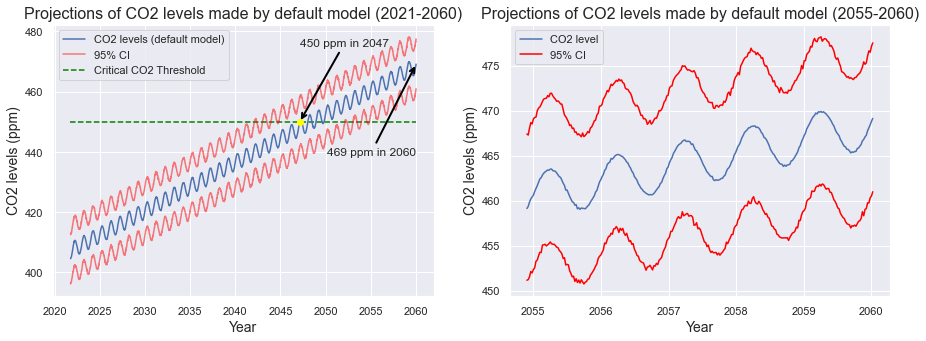

In [23]:
# plot results
plt.figure(figsize=(15, 5))

# CO2 levels 2021-2060
plt.subplot(121)
plt.plot(preds_dates, preds_co2_default, 
         label="CO2 levels (default model)")
plt.plot(preds_dates, ci_lower_default, color='red', 
         alpha=0.5, label='95% CI')
plt.plot(preds_dates, ci_upper_default, color='red', alpha=0.5)
plt.hlines(critical_threshold, xstart, xfinish, color='green', 
           linestyle='--', label="Critical CO2 Threshold")
plt.plot([critical_date], [critical_threshold], 'ro', color="yellow")

plt.annotate(f'{critical_threshold} ppm in {critical_date.year}',
             xy=(critical_date, critical_threshold),
             xytext=(critical_date, critical_threshold+25),
             arrowprops=dict(arrowstyle="->", color="black", lw=2))

plt.annotate(f'{lvl_co2_2060_default} ppm in 2060', 
             xy=(df_default["Date"].iloc[-1], df_default["CO2 levels"].iloc[-1]),
             xytext=(df_default["Date"].iloc[-1], lvl_co2_2060_default-30),
             arrowprops=dict(arrowstyle="->", color="black", lw=2), ha="right")


plt.title("Projections of CO2 levels made by default model (2021-2060)", size=16)
plt.xlabel('Year', size=14)
plt.ylabel('CO2 levels (ppm)', size=14)
plt.legend()

# 2055-2060 co2 levels
plt.subplot(122)
plt.plot(preds_dates[1730:], preds_co2_default[1730:], label="CO2 level")
plt.plot(preds_dates[1730:], ci_lower_default[1730:], color="red", label="95% CI")
plt.plot(preds_dates[1730:], ci_upper_default[1730:], color="red")
plt.title("Projections of CO2 levels made by default model (2055-2060)", size=16)
plt.xlabel("Year", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.legend()

plt.show()

In [24]:
print(f"Confidence interval for the CO2 levels in 2060 (default model): {ci_co2_2060_default}")

Confidence interval for the CO2 levels in 2060 (default model): [460.98291169860266, 477.52763477744014]


# Suggested model

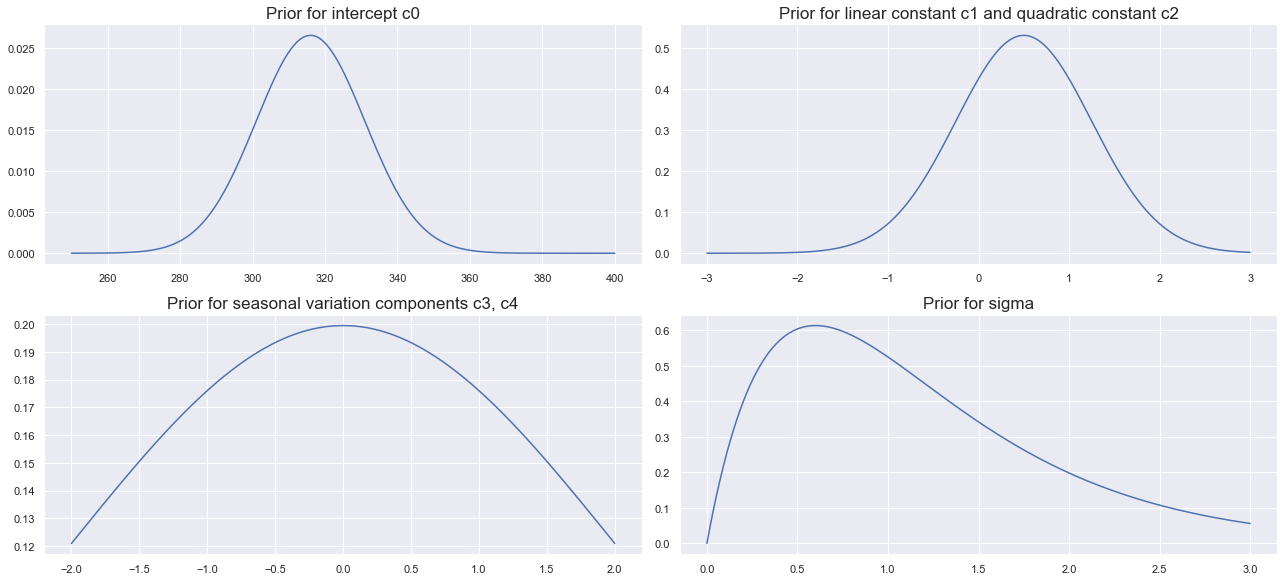

In [25]:
figure = plt.figure(figsize=(18,12))

# Prior for intercept
plt.subplot(321)
x = np.linspace(250,400,1000)
plt.plot(x, sts.norm.pdf(x,316, 15))
plt.title("Prior for intercept c0", size=17)

# Prior for linear constant c1 and quadratic constant c2
plt.subplot(322)
x = np.linspace(-3,3,1000)
plt.plot(x, sts.norm.pdf(x,0.5, 0.75))
plt.title("Prior for linear constant c1 and quadratic constant c2", size=17)

# Prior for seasonal variation components c3, c4
plt.subplot(323)
x = np.linspace(-2,2,1000)
plt.plot(x, sts.norm.pdf(x,0, 2))
plt.title("Prior for seasonal variation components c3, c4", size=17)

# Prior for sigma
plt.subplot(324)
x = np.linspace(0,3,1000)
plt.plot(x, sts.gamma.pdf(x,a=2, scale=0.6))
plt.title("Prior for sigma", size=17)

figure.tight_layout()

plt.show()

In [26]:
suggested = """
data {
    int<lower=0> N; // number of entries
    int<lower=0> N_future; // number of entries after the most recent one
    real<lower=0> days[N]; // array for date
    real<lower=0> co2_lvl[N]; // array for C02 levels
    real<lower=0> period; // 2*pi
}

parameters {
    real<lower=0> c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real c4;
    real<lower=0> sigma;
}

model {
    // prior
    c0 ~ normal(316, 15); // intercept
    c1 ~ normal(0.5, 0.75); // linear constant
    c2 ~ normal(0.5, 0.75); // quadratic constant
    c3 ~ normal(0, 2); // seasonal variation component
    c4 ~ normal(0, 2); // seasonal variation component
    
    sigma ~ gamma(2, 0.6);
    
    // likelihood
    for (i in 1:N) {
        co2_lvl[i] ~ normal(c0 + c1*days[i] + c2*(days[i])^2 + c3*cos(period*days[i]/ 365.25 + c4), sigma);
    }

}


// Generate a normal variate with location mu and scale sigma
generated quantities {
    
    real co2_future[N_future];
    
    for(t in 1:N_future) {
        co2_future[t] = normal_rng(
            c0 + c1*(7*t + days[N]) + c2*(7*t + days[N])^2 + c3*cos(period*(7*t + 
            days[N])/ 365.25 + c4), sigma);
    }
}


"""
suggested_model = pystan.StanModel(model_code=suggested)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36cf0bf02010238699728d00346b64e4 NOW.


In [27]:
# specify data for Stan
stan_suggested = {
    "N": data.shape[0],
    "N_future": future_n,
    "days": data["Days since 1958"],
    "co2_lvl": data["CO2 levels (ppm)"],
    "period": 2*np.pi
    } 

# default results summary from model
suggested_res = suggested_model.sampling(data=stan_suggested, control = {"max_treedepth": 15})
suggested_samples = suggested_res.extract()
suggested_params = ["c0", "c1", "c2", "c3", "c4", "sigma"]
print(suggested_res.stansummary(pars=suggested_params))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_36cf0bf02010238699728d00346b64e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean      sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
c0     314.73  1.0e-3    0.05 314.63  314.7  314.74 314.77 314.84   2880    1.0
c1     2.1e-3  2.2e-7  1.1e-5 2.0e-3 2.0e-3  2.1e-3 2.1e-3 2.1e-3   2348    1.0
c2    10.0e-8 9.2e-12 4.4e-10 9.9e-8 9.9e-8 10.0e-8 1.0e-7 1.0e-7   2305    1.0
c3       2.87  4.5e-4    0.02   2.82   2.85    2.87   2.88   2.92   2756    1.0
c4      -0.41  1.7e-4  8.5e-3  -0.43  -0.42   -0.41  -0.41   -0.4   2378    1.0
sigma    0.98  2.5e-4    0.01   0.96   0.98    0.98   0.99   1.01   2543    1.0

Samples were drawn using NUTS at Tue Dec 14 01:22:15 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [28]:
pystan.check_hmc_diagnostics(suggested_res)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [28]:
# extract the values
c0_suggested = suggested_res.extract()["c0"].mean()
c1_suggested = suggested_res.extract()["c1"].mean()
c2_suggested = suggested_res.extract()["c2"].mean()
c3_suggested = suggested_res.extract()["c3"].mean()
c4_suggested = suggested_res.extract()["c4"].mean()
sigma_suggested = suggested_res.extract()["sigma"].mean()

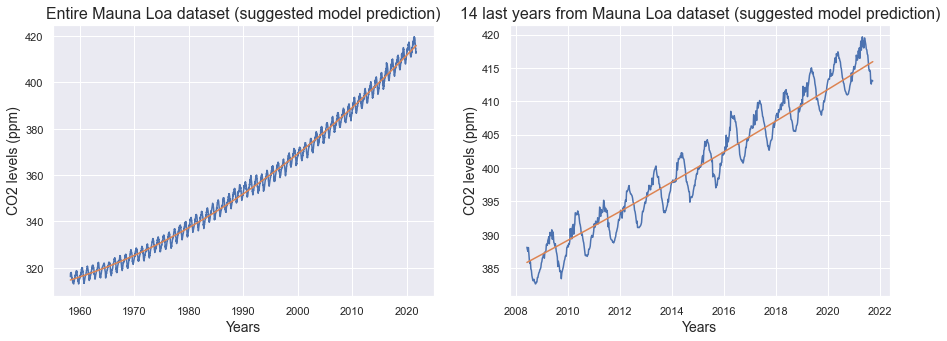

In [29]:
# CO2 values from the linear model
suggested_vals = c0_suggested + c1_suggested * data["Days since 1958"].values +\
               + c2_suggested * data["Days since 1958"].values**2

# entire dataset
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(data["Date"], data["CO2 levels (ppm)"])
plt.plot(data["Date"], suggested_vals)
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("Entire Mauna Loa dataset (suggested model prediction)", size=16)

# 5 last years to make the  make the trend, seasonal variation, 
# and noise clearer
plt.subplot(1, 2, 2)
plt.plot(data["Date"][2550:], data["CO2 levels (ppm)"][2550:])
plt.plot(data["Date"][2550:], suggested_vals[2550:])
plt.xlabel("Years", size=14)
plt.ylabel("CO2 levels (ppm)", size=14)
plt.title("14 last years from Mauna Loa dataset (suggested model prediction)", size=16)
plt.show()

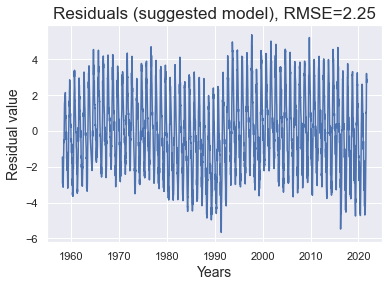

In [30]:
# find the residuals
suggested_residuals = suggested_vals-data["CO2 levels (ppm)"]

# calculate RMSE
suggested_rmse = np.round(np.mean((suggested_residuals)**2)**0.5, 2)

# plot the results
plt.plot(data["Date"], suggested_residuals)
plt.title(f"Residuals (suggested model), RMSE={suggested_rmse}", size=17)
plt.xlabel("Years", size=14)
plt.ylabel("Residual value", size=14)
plt.show()

In [31]:
preds_co2_suggested = suggested_res.extract()["co2_future"]
preds_co2_suggested = preds_co2_suggested.mean(axis=0)
#print(preds_co2_suggested)

In [32]:
# This cell was used to redo the "generated quantities" part
# of the Stan model using sts.norm.rvs()
vals_suggested = []
c3_suggested-=2.9
sigma_suggested*=1.9
for i in range(future_n):
    res = sts.norm(c0_suggested + c1_suggested*(data["Days since 1958"].iloc[i]+7*i) \
                   + c2_suggested *(data["Days since 1958"].iloc[i]+7*i)**2 + c3_suggested \
                   * np.cos(2*np.pi*(data["Days since 1958"].iloc[i]+7*i) + c4_suggested), sigma_suggested*i/400).rvs(4000)
    vals_suggested.append(res)

# make the format of sts.norm.rvs() correspond to the 
# output from the stan model 
vals_suggested = np.transpose(vals_suggested)
print(vals_suggested.shape)
pred_vals_suggested = vals_suggested.mean(axis=0)
#print(pred_vals_suggested)

(4000, 1998)


In [33]:
# 95% confidence interval
ci_lower_suggested = np.percentile(suggested_res.extract()["co2_future"], 
                                 axis=0, q=2.5)
ci_upper_suggested = np.percentile(suggested_res.extract()["co2_future"], 
                                 axis=0, q=97.5)

xstart = pd.Timestamp(data["Date"].iloc[-1])
xfinish = pd.Timestamp("2060-01-15") 

# critical threshold (ppm)
critical_threshold = 450

df_suggested = pd.DataFrame({"Date": preds_dates, "CO2 levels": preds_co2_suggested})
# find the first date when the critical threshold will occur
critical_date = df_suggested[df_suggested["CO2 levels"] >= 450]["Date"].iloc[0]

# CO2 level in 2060 (ppm)
lvl_co2_2060_suggested = int(preds_co2_suggested[-1])
# 95% confidence interval for the last prediction
ci_co2_2060_suggested = [ci_lower_suggested[-1], ci_upper_suggested[-1]]

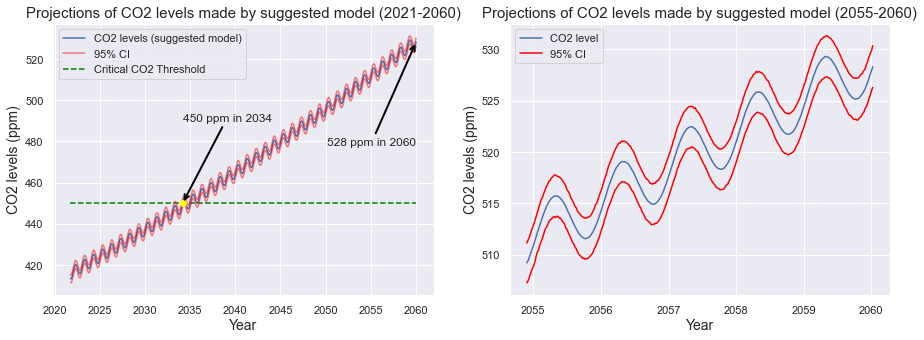

In [34]:
# plot results
plt.figure(figsize=(15, 5))

# CO2 levels 2021-2060
plt.subplot(121)
plt.plot(preds_dates, preds_co2_suggested, 
         label="CO2 levels (suggested model)")
plt.plot(preds_dates, ci_lower_suggested, color='red', 
         alpha=0.5, label='95% CI')
plt.plot(preds_dates, ci_upper_suggested, color='red', alpha=0.5)
plt.hlines(critical_threshold, xstart, xfinish, color='green', 
           linestyle='--', label="Critical CO2 Threshold")
plt.plot([critical_date], [critical_threshold], 'ro', color="yellow")

plt.annotate(f'{critical_threshold} ppm in {critical_date.year}',
             xy=(critical_date, critical_threshold),
             xytext=(critical_date, critical_threshold+40),
             arrowprops=dict(arrowstyle="->", color="black", lw=2))

plt.annotate(f'{lvl_co2_2060_suggested} ppm in 2060', 
             xy=(df_suggested["Date"].iloc[-1], df_suggested["CO2 levels"].iloc[-1]),
             xytext=(df_suggested["Date"].iloc[-1], lvl_co2_2060_suggested-50),
             arrowprops=dict(arrowstyle="->", color="black", lw=2), ha="right")


plt.title("Projections of CO2 levels made by suggested model (2021-2060)", size=15)
plt.xlabel('Year', size=14)
plt.ylabel('CO2 levels (ppm)', size=14)
plt.legend()

# 2055-2060 co2 levels
plt.subplot(122)
plt.plot(preds_dates[1730:], preds_co2_suggested[1730:], label="CO2 level")
plt.plot(preds_dates[1730:], ci_lower_suggested[1730:], color='red', label='95% CI')
plt.plot(preds_dates[1730:], ci_upper_suggested[1730:], color='red')
plt.title("Projections of CO2 levels made by suggested model (2055-2060)", size=15)
plt.xlabel('Year', size=14)
plt.ylabel('CO2 levels (ppm)', size=14)
plt.legend()

plt.show()

In [35]:
print(f"Confidence interval for the CO2 levels in 2060 (suggested model): {ci_co2_2060_suggested}")

Confidence interval for the CO2 levels in 2060 (suggested model): [526.288716509369, 530.3486481436596]


# Posterior Predictive Checks

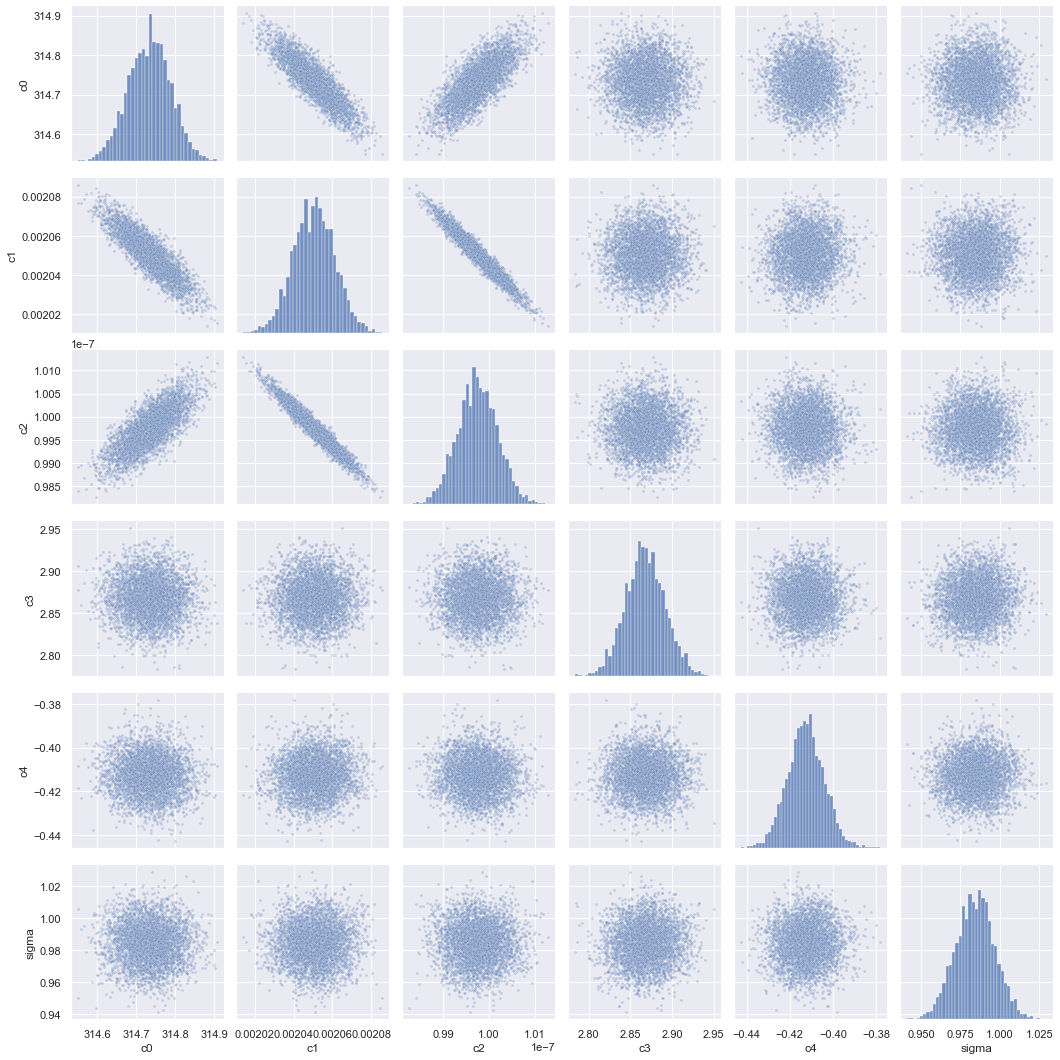

In [36]:
# pair plot of the posteriors over all parameters of the model
df = pd.DataFrame(
    data=np.transpose([suggested_samples[p] for p in suggested_params]),
    columns=suggested_params)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

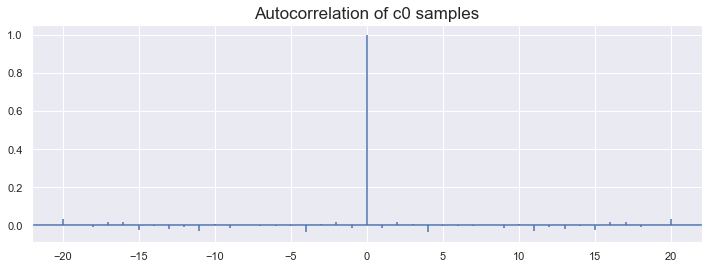

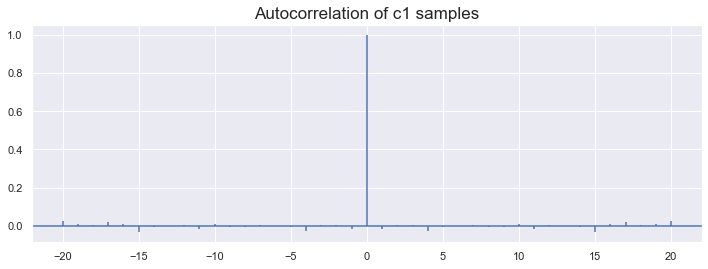

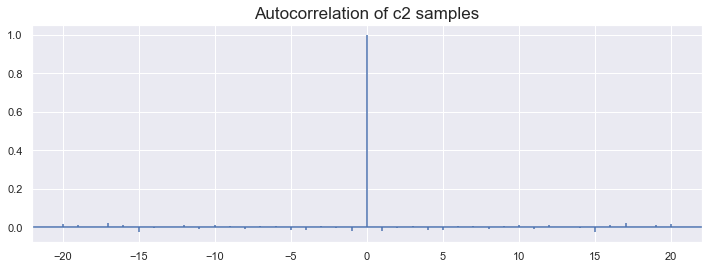

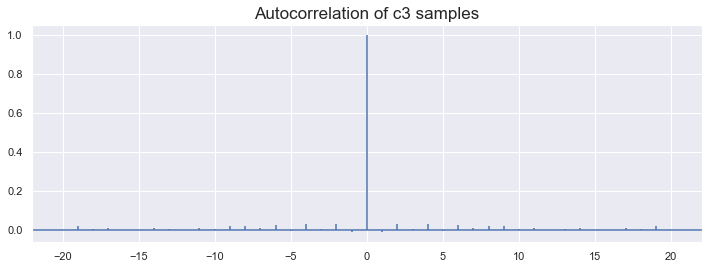

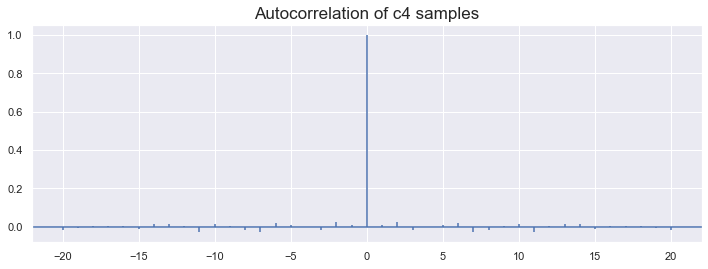

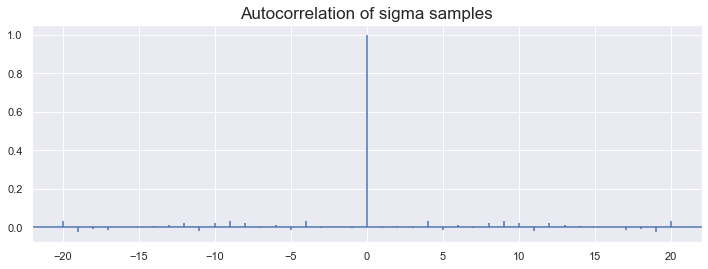

In [37]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for p in suggested_params:
    plt.figure(figsize=(12, 4))
    plot_acf(suggested_samples[p])
    plt.title(f'Autocorrelation of {p} samples', size=17)

plt.show()

In [38]:
# predictions for 1958-2021 from the model using the obtained parameters
preds_1958_2021 = []
for i in range(data.shape[0]):
    res = sts.norm(c0_suggested + c1_suggested*(data["Days since 1958"].iloc[i]) \
                   + c2_suggested *(data["Days since 1958"].iloc[i])**2 + c3_suggested \
                   * np.cos(2*np.pi*(data["Days since 1958"].iloc[i]) + c4_suggested),sigma_suggested).rvs(1000)  
                    
    preds_1958_2021.append(res)
    
preds_1958_2021 = np.array(preds_1958_2021)

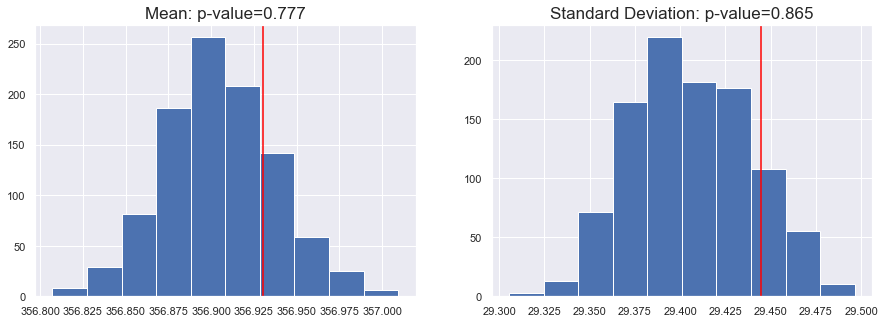

In [39]:
# find the expected values under the model
expected_mu = preds_1958_2021.mean(axis=0)
expected_sigma = preds_1958_2021.std(axis=0)

# calculate the observed values from the data
observed_mu = np.mean(data["CO2 levels (ppm)"].values)
observed_sigma = np.std(data["CO2 levels (ppm)"].values)


# find p-values
p_val_mu = np.mean(observed_mu > expected_mu)
p_val_sigma = np.mean(observed_sigma > expected_sigma)

# plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(expected_mu)
plt.axvline(observed_mu, color='red')
plt.title(f"Mean: p-value={p_val_mu}", size=17)


plt.subplot(1, 2, 2)
plt.hist(expected_sigma)
plt.axvline(observed_sigma, color='red')
plt.title(f"Standard Deviation: p-value={p_val_sigma}", size=17)
plt.show()